In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
library(brms)
library(haven) # to load the SPSS .sav file
library(tidyverse) # needed for data manipulation.
library(RColorBrewer) # needed for some extra colours in one of the graphs
library(ggmcmc)
library(ggthemes)
library(ggridges)

# IMPORT VISUALIZATION LIBRARIES:
library(data.table)
library(ggplot2)
library(ggridges)
library(dplyr)
library(tidyr)
library(scales)
library(viridis)

library(parallel)

In [4]:
df <- read.table('MAX_neutral_early_late.txt',header = TRUE,sep = ",")
df <-filter(df,Phase=='early')
df$se = sqrt(df$var)

In [10]:
iterations <- 20000
chains <- 4
SCALE <- 1
ns <- iterations*chains/2

dataTable <- select(df,Subj,ROI,beta,se,TvsS,TRAIT,STATE)
colnames(dataTable)[5] <- "cond"
qVars = 'cond,STATE,TRAIT'
EOI = 'Intercept,cond'
EOIq <- strsplit(qVars, '\\,')[[1]]
if(!('Intercept' %in% EOIq)) EOIq <- c('Intercept', EOIq)
EOIq <- intersect(strsplit(EOI, '\\,')[[1]], EOIq)
print(paste0('Effect of interest: ',EOIq))


dataTable$Subj <- factor(dataTable$Subj)
dataTable$ROI <- factor(dataTable$ROI)

# number of ROIs
nR <- nlevels(dataTable$ROI)

print(paste0('Number of subjects: ',nlevels(dataTable$Subj)))
print(paste0('Number of ROIs: ',nlevels(dataTable$ROI)))
print(paste0('Number of cores available: ', detectCores(all.tests = FALSE, logical = TRUE)))

# number of sigfigs to show on the table
nfigs <- 4

head(dataTable)

[1] "Effect of interest: Intercept" "Effect of interest: cond"     
[1] "Number of subjects: 109"
[1] "Number of ROIs: 36"
[1] "Number of cores available: 16"


,Subj,ROI,beta,se,cond,TRAIT,STATE
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MAX101,ACC,-0.008450,0.03363034,-0.5,-1.164152,-1.011495
2,MAX101,Left AntDorsal Insula,-0.048800,0.02981610,-0.5,-1.164152,-1.011495
3,MAX101,Left AntVentral Insula,-0.129348,0.04368066,-0.5,-1.164152,-1.011495
4,MAX101,Left Anterior Putamen,-0.014730,0.04275512,-0.5,-1.164152,-1.011495
5,MAX101,Left Anterior Caudate,-0.072463,0.03974921,-0.5,-1.164152,-1.011495
6,MAX101,Left Anterior MCC,0.049450,0.04815600,-0.5,-1.164152,-1.011495


In [6]:
# Set nuber of cores to use. 
# To run each chain on a single core, set number of core to 4
print(getOption("mc.cores"))
options(mc.cores = parallel::detectCores())
print(getOption("mc.cores"))

NULL
[1] 16


## **1. BML**

## Model 

<center> Y $\sim$ 1 + cond + state + trait + (1 + cond | SUB) + (1 + cond + state + trait | ROI) </center>

$$Y_{s,r} \sim Student(\nu,\mu_{s,r},\sigma^{2}_{s,r})$$  
$$\mu_{s,r} = \alpha + \alpha_{SUB} + \alpha_{ROI} + (\beta_{cond} + \beta_{SUB_{cond}} + \beta_{ROI_{cond}})*cond + (\beta_{state} + \beta_{ROI_{state}})*state + (\beta_{trait} + \beta_{ROI_{trait}})*trait $$


Where,  
$\mu_{s,r}$: Mean ROI response in the given subject for a particular phase and block type.     
_cond_: Threat (0.5) vs. Safe (-0.5)  
_state_: Subject's state score  
_trait_: Subject's trait score  

## Priors

$\alpha \sim Student(3,0,10)$ [population effect]  
$\alpha_{SUB} \sim Student(\nu_{SUB},0,\sigma_{SUB})$ [Subject effect]    
$\alpha_{ROI} \sim Student(\nu_{ROI},0,\sigma_{ROI})$ [ROI effect]  

$\beta_{cond} \sim Student(3,0,10)$ [population effect: cond]  
$\beta_{state} \sim Student(3,0,10)$ [population effect: state]    
$\beta_{trait} \sim Student(3,0,10)$ [population effect: trait]  

$\begin{bmatrix}
  \alpha_{ROI} \\
  \beta_{ROI_{cond}} \\
  \beta_{ROI_{state}} \\
  \beta_{ROI_{trait}}
\end{bmatrix} \sim MVNormal(\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \end{bmatrix},S)$

$ S = \begin{bmatrix} \sigma_{\alpha_{ROI}} & & & \\ & \sigma_{\beta_{ROI_{cond}}} & & \\ & & \sigma_{\beta_{ROI_{state}}} & \\ & & & \sigma_{\beta_{ROI_{trait}}} \end{bmatrix} R \begin{bmatrix} \sigma_{\alpha_{ROI}} & & & \\ & \sigma_{\beta_{ROI_{cond}}} & & \\ & & \sigma_{\beta_{ROI_{state}}} & \\ & & & \sigma_{\beta_{ROI_{trait}}} \end{bmatrix}$

$\begin{bmatrix}
  \alpha_{SUB} \\
  \beta_{SUB_{cond}}
\end{bmatrix} \sim MVNormal(\begin{bmatrix} 0 \\ 0 \end{bmatrix},S)$

$ S = \begin{bmatrix} \sigma_{\alpha_{SUB}} & \\ & \sigma_{\beta_{SUB_{cond}}} \end{bmatrix} R \begin{bmatrix} \sigma_{\alpha_{SUB}} & \\ & \sigma_{\beta_{SUB_{cond}}} \end{bmatrix}$


$\sigma_{SUB} \sim HalfStudent(3,0,10)$ [prior stddev for Subject effect]    
$\sigma_{ROI} \sim HalfStudent(3,0,10)$ [prior stddev for ROI effect]    
$\nu_{SUB} \sim \Gamma(3.325,0.1)$ [Subject effect hyperprior]    
$\nu_{ROI} \sim \Gamma(3.325,0.1)$ [ROI effect hyperprior]  

$\sigma_{\alpha} \sim HalfStudent(3,0,10)$ [prior stddev among intercepts]  
$\sigma_{\beta} \sim HalfStudent(3,0,10)$ [prior stddev among slopes]

$R \sim LKJcorr(2)$ [prior of correlation matix]


In [9]:
mod = '1 + cond + STATE + TRAIT'
modelForm = paste('beta | se(se) ~',
                  mod,'+ (1 + cond | gr(Subj, dist= "student")) +   
                         (',mod,'| gr(ROI, dist="student"))')
priorRBA <- get_prior(formula = modelForm,data=dataTable,family = 'student')
priorRBA$prior[2:4] <- "student_t(3,0,10)"
priorRBA$prior[5:7] <- "lkj(2)"
priorRBA$prior[8:9] <- "gamma(3.325,0.1)"
priorRBA$prior[11] <- "gamma(3.325,0.1)"
priorRBA$prior[13:14] <- "student_t(3,0,10)"
priorRBA$prior[18:19] <- "student_t(3,0,10)"
print(priorRBA)

                 prior     class      coef group resp dpar nlpar bound
1                              b                                      
2    student_t(3,0,10)         b      cond                            
3    student_t(3,0,10)         b     STATE                            
4    student_t(3,0,10)         b     TRAIT                            
5               lkj(2)       cor                                      
6               lkj(2)       cor             ROI                      
7               lkj(2)       cor            Subj                      
8     gamma(3.325,0.1)        df             ROI                      
9     gamma(3.325,0.1)        df            Subj                      
10 student_t(3, 0, 10) Intercept                                      
11    gamma(3.325,0.1)        nu                                      
12 student_t(3, 0, 10)        sd                                      
13   student_t(3,0,10)        sd             ROI                      
14   s

In [ ]:
fm <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          prior = priorRBA,
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

Start sampling



In [16]:
cat(capture.output(summary(fm)),sep = '\n', append=TRUE)

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: beta | se(se) ~ 1 + TvsS + STATE + TRAIT + (1 + TvsS | gr(Subj, dist = "student")) + (1 + TvsS + STATE + TRAIT | gr(ROI, dist = "student")) 
   Data: dataTable (Number of observations: 7848) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~ROI (Number of levels: 36) 
                     Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
df                      30.80     17.93     7.22    74.30 1.00      544
sd(Intercept)            0.05      0.01     0.03     0.06 1.00     2600
sd(TvsS)                 0.05      0.01     0.04     0.07 1.00     4771
sd(STATE)                0.01      0.00     0.01     0.02 1.00     8783
sd(TRAIT)                0.01      0.00     0.01     0.02 1.00     7214
cor(Intercept,TvsS)      0.48      0.14     0.19     0.72 1.00     4845
cor(Intercept,STATE)     0.02      0.20    -0.37     0.41

In [17]:
# Extract posteriors for fixed (aa) and random effects (bb)
aa <- fixef(fm, summary = FALSE)/SCALE # Population-Level Estimates
bb <- lapply(ranef(fm, summary = FALSE), `/`, SCALE) # Extract Group-Level (or random-effect)

## Functions

In [26]:
# Following functions add the "the poaterior of the global intercept with the intercept posterior of each roi"
# bb[['ROI']][,,tm] is a matrix with columns containing posteriors for every ROI
# aa[,tm] is a single column posterior for the global intercept.
psROI <- function(aa, bb, tm) {
  ps <- apply(bb[['ROI']][,,tm], 2, '+', aa[,tm])
  return(ps)
}
# apply(X,axis,func,..)
# check help for apply (?apply)


# compute P+
cnt <- function(x, ns) return(sum(x>0)/ns)
# summary for ROIs: nd - number of digits to output
sumROI <- function(R0, ns, nd) {
  hubs <- data.frame(cbind(apply(R0, 2, mean), apply(R0, 2, sd), apply(R0, 2, cnt, ns), t(apply(R0, 2, quantile, 
      probs=c(0.025, 0.05, 0.5, 0.95, 0.975)))))
  names(hubs) <- c('mean', 'SD', 'P+', '2.5%', '5%', '50%', '95%', '97.5%')
  return(round(hubs,nd))
}

################################# conventional GLM ############################################
sumGLM <- function(ll, tm, nR, DF, nd) {
   th <- qt(c(0.025, 0.05, 0.5, 0.95, 0.975), DF)
   rr <- matrix(0, nrow = nR, ncol = 8, dimnames=list(levels(dataTable$ROI), c('mean', 'SD', '2-sided-p', '2.5%', '5%', '50%', '95%', '97.5%')))
   rownames(rr) <- levels(dataTable$ROI)
   if(tm == 'Intercept') tm <- '(Intercept)'
   for(ii in 1:nR) {
     u1 <- ll[[ii]]$coefficients[tm,1] # mean
     u2 <- ll[[ii]]$coefficients[tm,2] # sd
     u3 <- ll[[ii]]$coefficients[tm,4] # 2-sided p
     rr[ii,] <- round(c(u1, u2, u3, u1+u2*th),nd)
   } 
   return(rr)
}

################################# function to plot posteriors ##################################
plotPDP <- function(ps0,gg_brm,gg_glm){
rois <- colnames(ps0) # Global intercept + ROI intercepts
nobs=dim(ps0)[1] # gets number of rows and assigns it to nobj

# initialize a single column dataframe with number of row equal to number of rois
data_stats = data.frame(1:length(rois)) 
data_stats$ROI <- rois # adds an ROI column with roi names

#data_stats$mean <- colMeans(data)
data_stats$brmMean <- gg_brm$mean # Adds a brmMean columns
data_stats$glmMean <- gg_glm$mean # Adds a brmMean columns

# gets proportion of the posterior greater than 0 for each roi
data_stats$P <- colSums(ps0 > 0)/nobs 
# gets proportion of the posterior less than 0
#data_stats$Pn <- 1 - data_stats$P
data_stats$Pn <- data_stats$P
for (i in 1:length(rois)) {
  if (data_stats$P[i]<.5){data_stats$Pn[i]=1-data_stats$P[i]}
}

# this will order the distributions correctly
#data_stats <- data_stats[order(data_stats$brmMean),]
data_stats <- data_stats[order(data_stats$P),]

data_trans <- as.data.frame(t(as.matrix(ps0)))
data_trans <- tibble::rownames_to_column(data_trans, "ROI")
data_trans$X <- 1:nrow(data_trans)

# merge values & stats into one table by ROI
data_merge <- merge(data_stats, data_trans, by = "ROI")
data_merge <- data_merge[order(data_merge$X),]

# Transform data into long form
# Melt dataframe by ROI
library(data.table)

data_long <- melt(data_trans, id=c("ROI","X"))
data_long <- data_long[order(data_long$X),]

# This is incredibly clunky, but for the sake of time adding stats by ensuring orders are all the same and repeating each value 2000 times... Tried a few different methods with no success for some reason. 

data_long$brmMean <- rep(data_merge$brmMean, each = nobs)
data_long$glmMean <- rep(data_merge$glmMean, each = nobs)
data_long$P <- rep(data_merge$P, each =nobs)
data_long$Pn <- rep(data_merge$Pn, each =nobs)

# set your labels here so you don't have to change within the plot below: 
format(round(1, 2), nsmall = 2)

y.axis.labs <- format(round(data_stats$P,3), nsmall = 2)                        # y axis labels
sec.y.axis.labs <- data_stats$ROI                             # second y axis labels (probabilities)

 # X AXIS LABELS NEED TO CHANGE TO CORRESPOND TO DATA SET! UNCOMMENT WHICHEVER MATCHES

# Uncomment for THREAT
x.axis.labs <- c( "Safe > Threat", "0", "Threat > Safe")                 # x axis labels  THREAT
x.labs.pos <- c(-0.2, 0, 0.2)                                             # x axis position THREAT

#graph.title <- data.name                                   # graph title 
legend.title <- "Probability"                              # legend title
y.axis.title <- NULL                                       # for now ...
x.axis.title <- NULL                                       # for now...

# GRAPH DATA
library(repr)
options(repr.plot.width=10,repr.plot.height=8)

dataset <- data_long
x.values <- data_long$value                               # x values
y.values <- data_long$ROI                                 # y values
y.values.RO <- data_long$value                            # values to reorder Y by
distrib.fill <- data_long$Pn                              # fill graph with probabilities
group <- data_long$ROI

# Other aspects
gradient.colors <- c("yellow","#C9182B","#41245C")        # change gradient colors here (currently, yellow - purple)
label.size <- 16                                         # adjust ROI and probability y-axis font size
title.size <- 32                                         # adjust graph title size 
x.axis.size <- 16                                        # adjust x-axis label sizes

# here is where you can change information about the graph and add other characteristics using ggplot and ggridges


ggplot(dataset, aes(x = x.values, y = as.numeric(reorder(y.values, y.values.RO)), 
                    fill = distrib.fill, group = group)) +                      # scale = spacing, alpha = transparency
  coord_cartesian(xlim = c(-0.25, 0.25)) +
  stat_density_ridges(quantile_lines = TRUE, 
                      quantiles = 2, 
                      alpha = .95, 
                      scale = 1,
                      color = "black",
                      size = .35
                     ) +
    geom_segment(aes(x = glmMean, xend = glmMean, y = as.numeric(reorder(y.values, y.values.RO)),
                                      yend = as.numeric(reorder(y.values, y.values.RO))+0.9), color = "red") +           # divide into two quantiles (show mean)
  geom_vline(xintercept = 0, linetype="solid",color = "black",alpha = .95, size = .45) +    #create line at X = 0
  scale_fill_gradientn(colors = viridis_pal(direction = 1, option = "inferno")(20),                         # set gradient
                       limits = c(.85,1),                                # which probabilites matter?
                       na.value = "#909497",                                # if not in limits, gray out
                       name = legend.title) +                            # name legend
  scale_y_continuous(breaks = 1:length(rois),                            # A VERY HACK-Y WAY TO HAVE TWO Y AXES W DISCRETE DATA
                     expand = c(0,0),
                     labels = y.axis.labs,                               # Trick ggplot into thinking data is continuous...
                     sec.axis = sec_axis(~.,                             # Second axis to show probabilities
                                         breaks = 1:length(rois),
                                         labels = sec.y.axis.labs)) +
  #theme_ridges(font_size = label.size, grid = TRUE, center_axis_labels = TRUE) +  # theme info
  #ggtitle(graph.title)+ 
  #theme_bw() +# graph title
 #theme_ridges(grid = FALSE) + 
  theme(   
    panel.background = element_blank(),
    #legend.position = "none",
    #panel.grid.major.y = element_line(color = "grey"), 
    plot.title = element_text(hjust = 0.5, size = title.size),            # plot title size and position
    axis.text.y = element_text(size=label.size),                               # y-axis text size
    axis.line.x = element_line(color = "gray"),
    axis.text.y.right = element_text(size = label.size),                  # y-axis info for right axis
    axis.text.x = element_text(size = x.axis.size),
    #plot.margin = unit(c(0,0,0,0), "cm"),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(),
    legend.title.align = 5)+
  guides(shape = guide_legend(label.position = "bottom",
                              title.positon = "bottom",
                              title.vjust = 0.4)) +          
  labs(
    x = NULL,                                                         # Add or not add X and Y labels
    y = NULL) +
  scale_x_continuous(breaks = x.labs.pos, labels = c(x.axis.labs))
}

## **2. BML and GLM Summaries with Posterior Plots**

===== Summary of region effects for Intercept (RBA results) =====
                            mean     SD     P+    2.5%      5%     50%     95%
ACC                      -0.0135 0.0111 0.1096 -0.0351 -0.0318 -0.0136  0.0049
Left AntDorsal Insula     0.0473 0.0109 1.0000  0.0259  0.0295  0.0473  0.0652
Left Anterior  Putamen   -0.0179 0.0115 0.0601 -0.0404 -0.0368 -0.0179  0.0011
Left Anterior Caudate    -0.0214 0.0111 0.0272 -0.0429 -0.0394 -0.0215 -0.0031
Left Anterior MCC         0.0481 0.0116 1.0000  0.0254  0.0290  0.0480  0.0670
Left Anterior Thalamus   -0.0655 0.0114 0.0000 -0.0878 -0.0844 -0.0654 -0.0465
Left AntVentral Insula    0.0290 0.0119 0.9926  0.0059  0.0096  0.0289  0.0484
Left BLBM Amygdala       -0.0082 0.0136 0.2717 -0.0351 -0.0305 -0.0082  0.0142
Left BST                  0.0220 0.0188 0.8810 -0.0150 -0.0088  0.0219  0.0532
Left CeMe Amygdala       -0.0525 0.0161 0.0010 -0.0837 -0.0789 -0.0526 -0.0260
Left Hypothalamus         0.0225 0.0170 0.9072 -0.0106 -0.0054  0

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00162



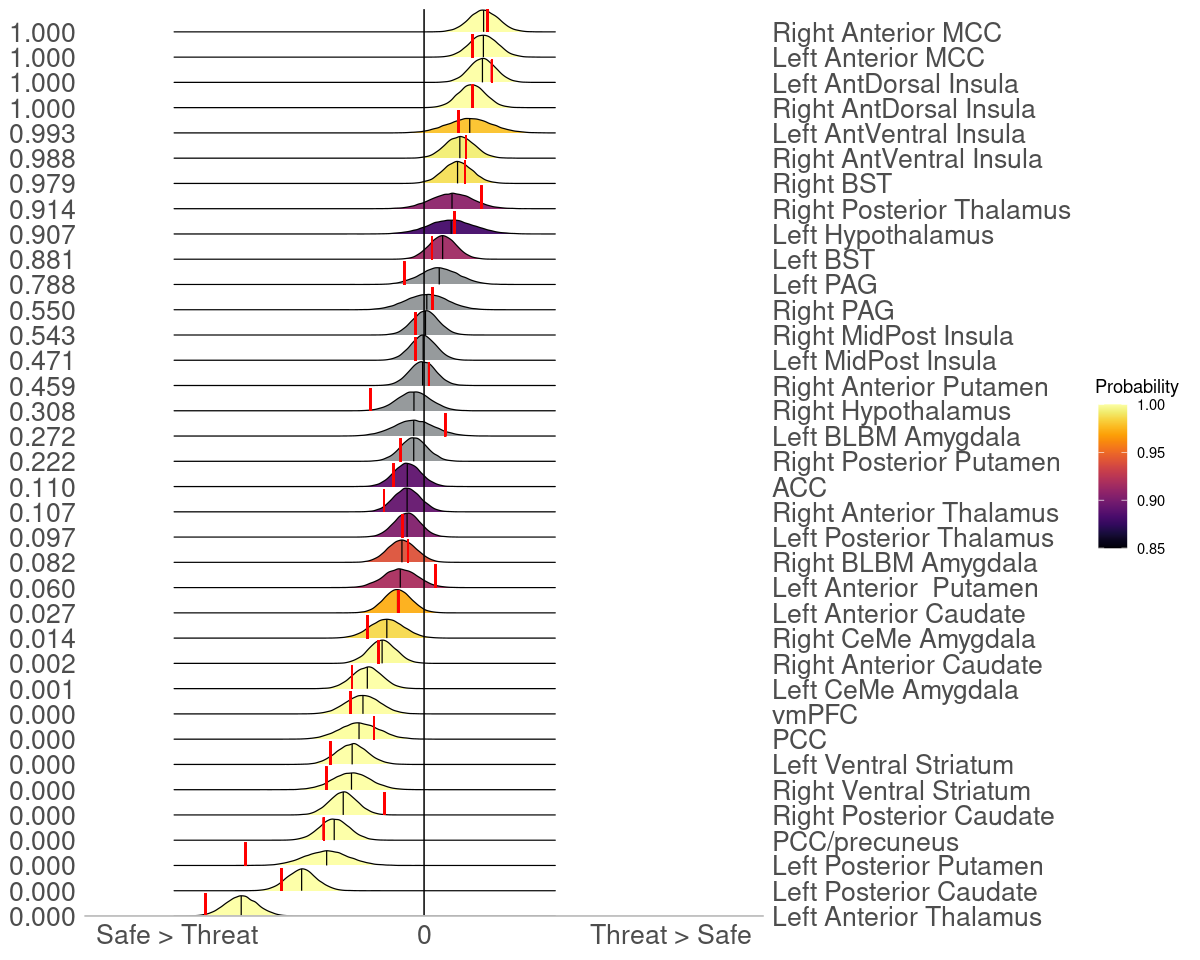

In [27]:
# for Intercept and quantitative variables
ii = 1
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('beta ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for TvsS (RBA results) =====
                            mean     SD     P+    2.5%      5%     50%     95%
ACC                      -0.0013 0.0167 0.4682 -0.0340 -0.0284 -0.0014  0.0264
Left AntDorsal Insula     0.0251 0.0163 0.9381 -0.0071 -0.0018  0.0251  0.0522
Left Anterior  Putamen    0.0011 0.0178 0.5233 -0.0335 -0.0282  0.0010  0.0304
Left Anterior Caudate     0.0310 0.0171 0.9664 -0.0020  0.0032  0.0310  0.0594
Left Anterior MCC         0.0705 0.0182 0.9999  0.0351  0.0408  0.0702  0.1007
Left Anterior Thalamus    0.0107 0.0179 0.7242 -0.0246 -0.0186  0.0107  0.0401
Left AntVentral Insula   -0.0025 0.0187 0.4430 -0.0395 -0.0334 -0.0027  0.0282
Left BLBM Amygdala       -0.0133 0.0216 0.2714 -0.0559 -0.0488 -0.0130  0.0218
Left BST                  0.0339 0.0307 0.8656 -0.0259 -0.0164  0.0338  0.0846
Left CeMe Amygdala       -0.0601 0.0267 0.0120 -0.1131 -0.1039 -0.0598 -0.0164
Left Hypothalamus         0.0367 0.0275 0.9076 -0.0175 -0.0087  0.0370

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.0026



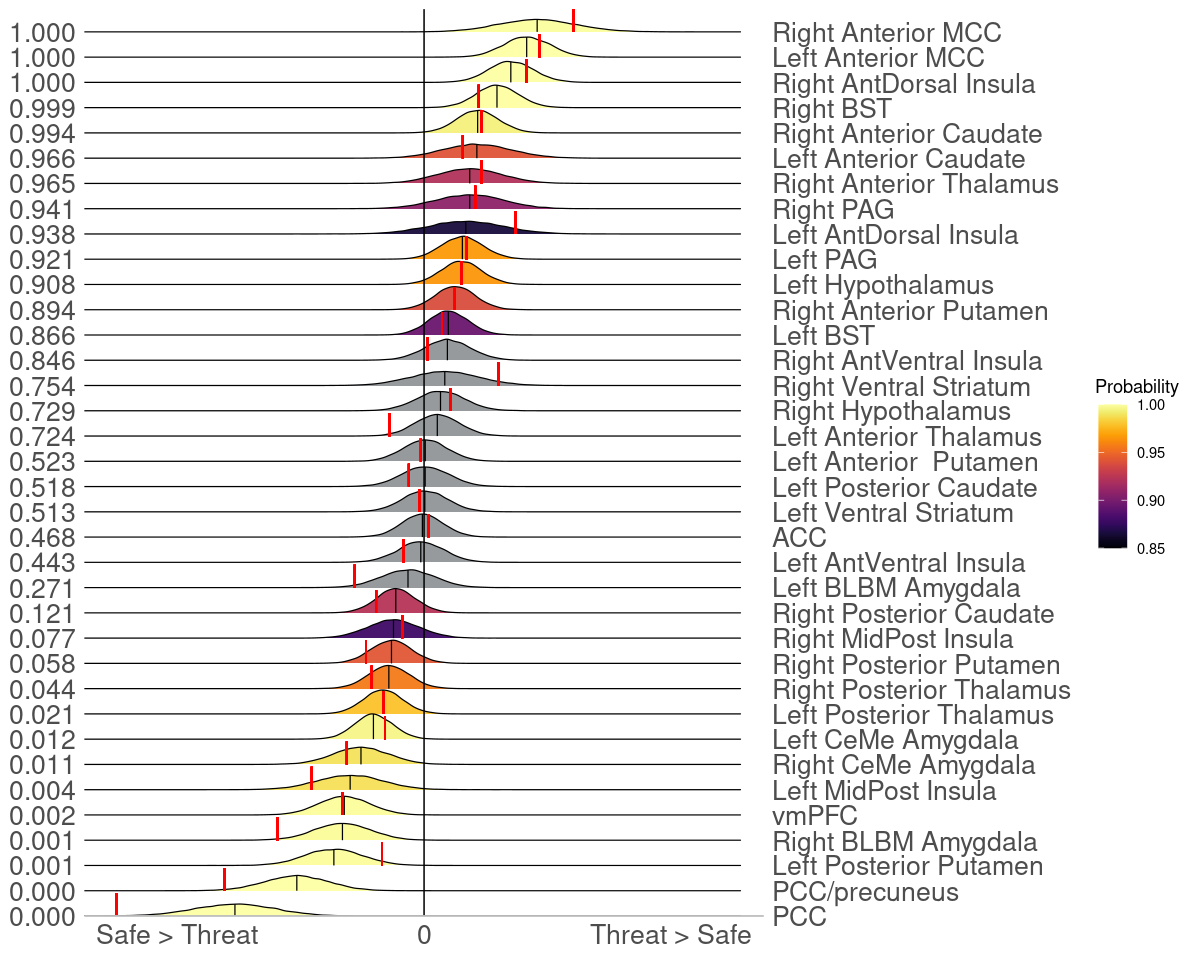

In [28]:
# for Intercept and quantitative variables
ii = 2
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('beta ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

In [29]:
save.image(file="MAX_neutral_early.RData")

## **3. Posterior Predictive Check**

Warning message:
“Removed 6531 rows containing non-finite values (stat_density).”
Warning message:
“Removed 11 rows containing non-finite values (stat_density).”


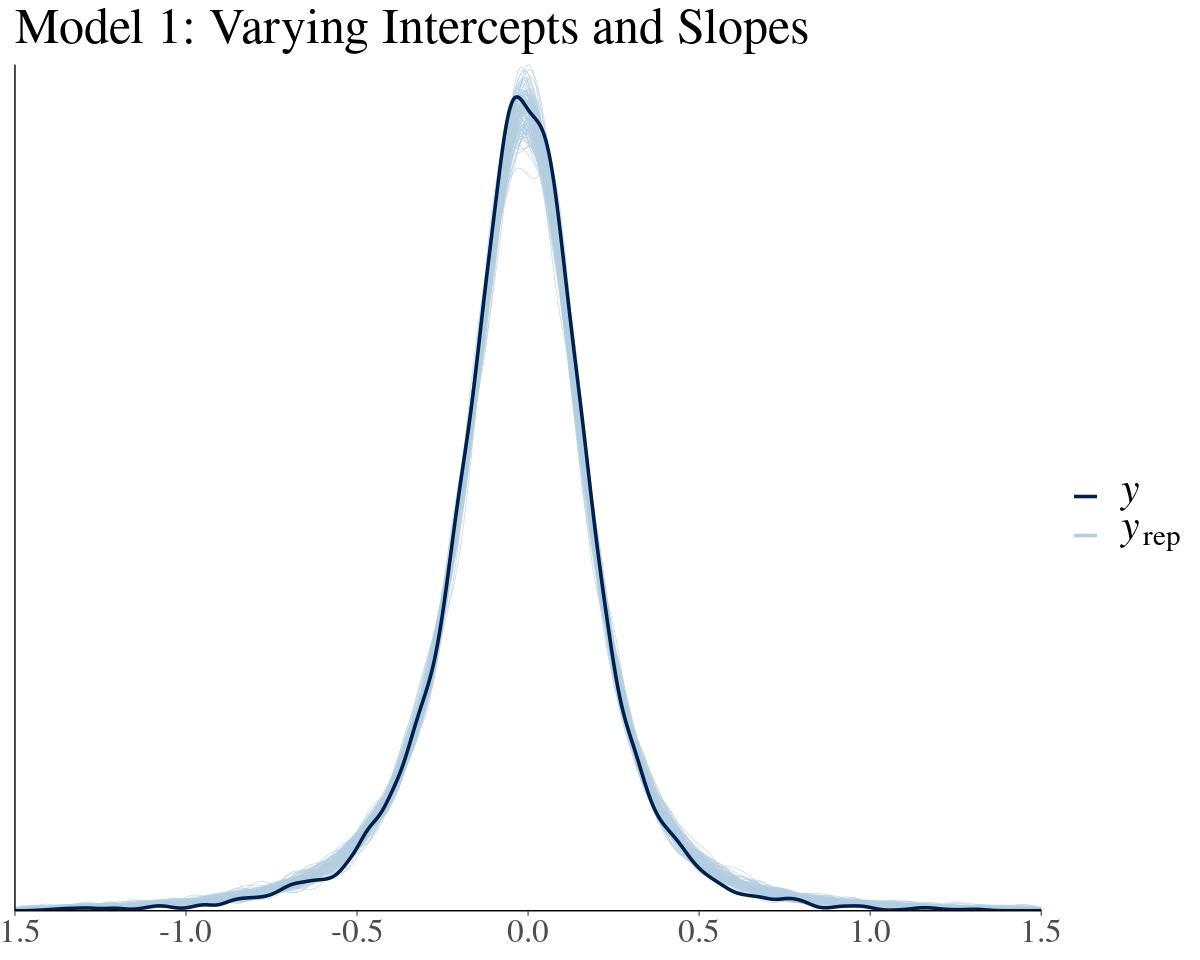

In [30]:
pp_plot = pp_check(fm,nsamples = 100)
pp_plot + xlim(-1.5,1.5) + theme(text = element_text(size=25),legend.text=element_text(size=25)) + ggtitle("Model 1: Varying Intercepts and Slopes",)